In [292]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import dill as pickle
from pyseir.load_data import *
from pyseir.utils import REF_DATE
from datetime import timedelta
from pyseir.testing.test_strategy_simulator import TestStrategySimulator
from pyseir.testing.plots import *
from pyseir.inference.fit_results import load_Rt_result
import seaborn as sns
import matplotlib.pyplot as plt
from pyseir.testing.load_data import load_projection, load_rt
from pyseir.inference.infer_rt import run_state as run_rt_inference
from pyseir.deployment.demographic_mapper import DemographicMapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get demographic mapper result

Assuming demographic mapper result and Rt inference are ready...

Assuming following data for a worksite (lots of wild assumptions ...)
- population size at worksite: 1000
- PCR cost per individual = 250
- PCR sensitivity (P(positive PCR | infected)) = 0.7
- Antibody test cost per individual = 120
- Antibody test sensitivity on detecting immunity (P(positive Antibody | immune)) = 0.5
- Max PCR availability per month = population size at worksite
- Max antibody test availability (distributed before worksite re-open) = population size at worksite
- Mininum number of cases for outbreak per month = 5
- Cost of hospitalization due to covid = 3000 
- Frac of contact(ppl) that will be active at site (fraction of worker back to worksite at first, worker with antibody   test positive gets priority)   = 0.5
- Cost of worksite closure = 200000

In [172]:
FIPS = '06'

### Infer Rt

/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
Did not match 50 counties to fips data.
                                                   county state  \
20                                        Alexandria City    VA   
26                                   Charlottesville City    VA   
35                                      Harrisonburg City    VA   
43                                      Newport News City    VA   
44                                           Norfolk City    VA   
...                                                   ...   ...   
180968  Yakutat City and Borough, Skagway Municipality...    AK   
180969  Yakutat City and Borough, S

ERROR:root:Removing duplicates: [False False False ... False False False]
/anaconda3/envs/pyseir/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
20                                        Alexandria City    VA   
26                                   Charlottesville City    VA   
35                                      Harrisonburg City    VA   
43                                      Newport News City    VA   
44                                           Norfolk City    VA   
...                                                   ...   ...   
180968  Yakutat City and Borough, Skagway Municipality...    AK   
180969  Yakutat City and Borough, Skagway Municipality...    AK   
1

ERROR:root:Removing duplicates: [False False False ... False False False]
/Users/xzhang/Documents/covid/covid-data-model/pyseir/inference/infer_rt.py:500: RuntimeWarning: Mean of empty slice
  df_all[["Rt_MAP__new_cases", "Rt_MAP__new_deaths"]], axis=1


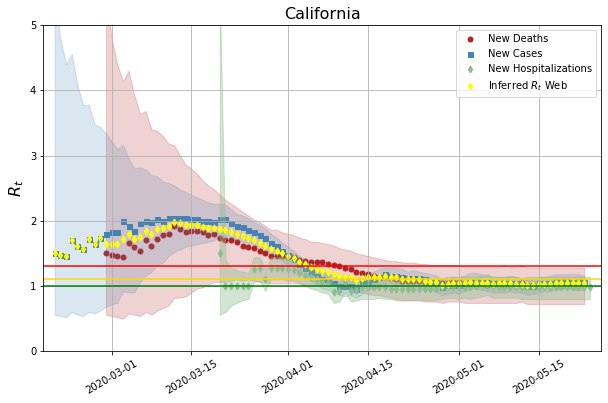

In [3]:
run_rt_inference(state=FIPS, states_only=True)

### Run testing strategy simulation

#### Scenario I. Optimal pcr coverage and frequency at a given budget

**Assuming budget for pcr test is $100000 per month**

In [311]:
ts = TestStrategySimulator(fips=FIPS, 
                               antibody_coverage = [1],
                               date=Rt.index[-1],
                               max_pcr_cost_per_month=100000)

ts.run()
optimized = ts.optimize(by='outbreak_prob')
params, metrics = ts.reformat_optimization_results(optimized)

#### Optimal testing parameters and metrics are

In [307]:
params

,optimal
antibody_coverage,1.0
pcr_coverage per month,0.1
pcr_frequency per month,4.0


In [308]:
metrics

,metrics
delta_p_infected per month,0.000843
delta_immunity per month,0.007760
prevented_secondary_transmission per month,0.220858
delta_covid_index per month,0.006986
test_cost_pcr per month,100000.000000
outbreak_prob per month,0.435648
delta_outbreak_prob per month,0.212754
avoided_cost per month,63507.709630
hospitalization_cost_no_test per month,285.651845
worksite_outbreak_cost_no_test per month,15507.761448


#### Scenario II. Optimal pcr coverage and frequency at a given budget

In [314]:
pcr_test_costs_per_month = np.linspace(10000, 500000, 100)
pcr_covs = list()
pcr_freqs = list()
ab_covs = list()
outbreak_prob = list()
pcr_test_cost = list()
results = list()
for max_pcr_cost_per_month in pcr_test_costs_per_month:
    ts = TestStrategySimulator(fips=FIPS, 
                               antibody_coverage = [1],
                               date=Rt.index[-1],
                               pcr_frequency=np.linspace(1, 8, 8),
                               max_pcr_cost_per_month=max_pcr_cost_per_month)

    ts.run()
    optimized = ts.optimize(by='outbreak_prob')
    pcr_test_cost.append(optimized['test_cost_pcr'])
    pcr_covs.append(optimized['pcr_coverage']) 
    pcr_freqs.append(round(optimized['pcr_frequency'] ))
    ab_covs.append(optimized['antibody_coverage'])
    outbreak_prob.append(optimized['outbreak_prob'])
    results.append(ts.results)
    
test_results = pd.DataFrame({'pcr_test_costs_per_month': pcr_test_cost,
                             'pcr_coverage': pcr_covs,
                             'pcr_frequency_per_month': pcr_freqs,
                             'outbreak_prob': outbreak_prob})

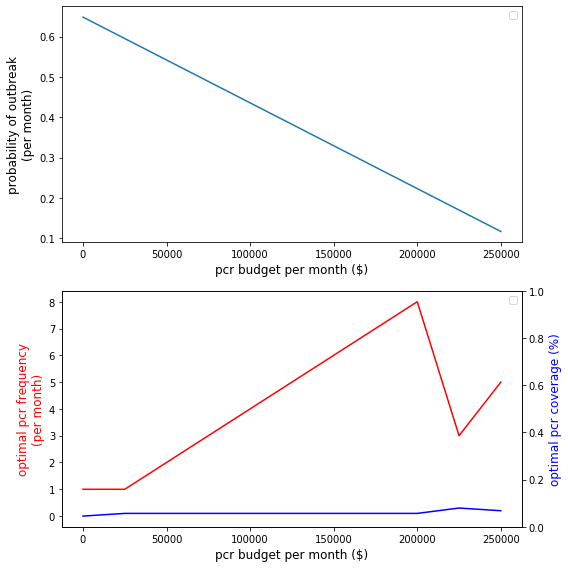

In [315]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# optimal outbreak probability
test_results.plot(x='pcr_test_costs_per_month', y='outbreak_prob', ax=axes[0], label='')
axes[0].set_ylabel('probability of outbreak\n(per month)', fontsize=12)

# optimal pcr frequency
test_results.plot(x='pcr_test_costs_per_month', y='pcr_frequency_per_month', 
                  ax=axes[1], color='r', label='')
axes[1].set_ylabel('optimal pcr frequency\n(per month)', color='r', fontsize=12)

# optimal pcr coverage
ax2 = axes[1].twinx() 
test_results.plot(x='pcr_test_costs_per_month', y='pcr_coverage', 
                  ax=axes[1], color='b', label='')
ax2.set_ylabel('optimal pcr coverage (%)', color='b', fontsize=12)


axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[0].set_xlabel('pcr budget per month ($)', fontsize=12)
axes[1].set_xlabel('pcr budget per month ($)', fontsize=12)

fig.tight_layout()
plt.show()

#### Scenario III. Saved Cost associated with worksite closure given different levels of testing

[53188.60969107249, 106377.21938214498, 159565.82907321746, 265943.04845536244]


Text(0, 0.5, 'saved cost associated with worksite closure ($)')

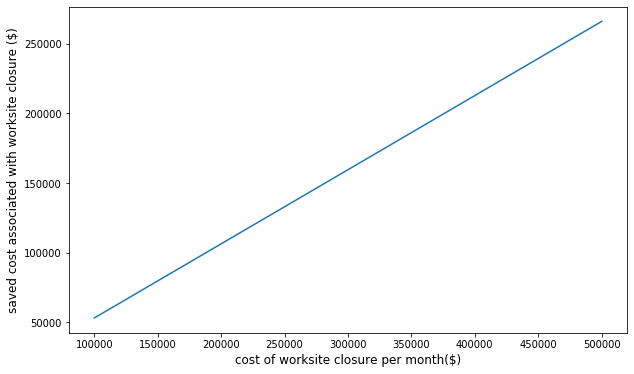

In [335]:
site_closure_costs = [100000, 200000, 300000, 500000]
delta_cost_worksite_closure = list()
for site_closure_cost in site_closure_costs:
    ts = TestStrategySimulator(fips=FIPS, 
                               antibody_coverage=[1],
                               pcr_coverage=[1],
                               pcr_frequency=[1], 
                               date=Rt.index[-1],
                               site_closure_cost=site_closure_cost,
                               max_pcr_cost_per_month=1000000000)

    ts.run()
    delta_cost_worksite_closure.append(ts.results['delta_closure_cost'].iloc[0])

print(delta_cost_worksite_closure)
plt.figure(figsize=(10, 6))
plt.plot(site_closure_costs,
         delta_cost_worksite_closure,
         label=f'pcr test {freq} times per month')
plt.xlabel('cost of worksite closure per month($)', fontsize=12)
plt.ylabel('saved cost associated with worksite closure ($)',
          fontsize=12)